# PyTorch Workflow

The typical` DL/ML workflow in PyTorch involves:

- Preparing and loading collected data
- Building models
- Fitting/Training the model on the data
- Making Predictions aka. Inference
- Saving and reloading trained models
- Putting it all together

In [38]:
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Check for PyTorch version
torch.__version__

# Setting up a device agnostic code
if torch.cuda.is_available():
  torch.set_default_device("cuda")
else:
  torch.set_default_device("cpu")

'2.1.1+cu118'

## Data (Preparing and Loading)

Machine Learning is a game of two parts:
- Get data into numerical representation
- Build a model to learn patterns in that data

To showcase this, lets create some known data using linear regression formula. We will make a straight line with known **parameters**.

> While creating models we come across the concept of features and labels. Features are the characteristics that the model will evaluate from the training data input and labels are the entities or names or values the model is trained to associate the features to. For example, a CNN trained on a dataset of celebrity faces will have the image of their faces as the feature data and the name of the celebrity will be the feature's label. 


In [39]:
# Establishing known parameters
weight = 0.7 # eight is the coefficient of the weighted sum
bias = 0.3 # bias is an additional constant to be added to the weighted sum to threshold the activation
start = 0
end = 1
step = .02
X = torch.arange(start, end, step).unsqueeze(dim=1)
# We created a range of numbers from 0 to 1 with steps of 0.02 and then wrapped each number in another dimension so the dimension of X will be ([50,1])
Y = weight * X + bias
# We map each element of X to Y with a function
# print(f"x:{X[:10]}\ny:{Y[:10]}")
# print(len(X), len(Y), X.shape, Y.shape)


### Splitting data into learning and testing sets

One of the most important concepts in machine learning is dividing our data into a set that we learn the patterns from and a set on which we validate our model.

There are three types of datasets in machine learning:
- The training set
- The validation set
- The test set

This is done to generalize our models(make sure it is able to work on datasets that it has never seen before.)

In [40]:
# Creating a training and testing set of our data

train_split = int(.8 * len(X)) 
# We index with integers so it is crucial to convert it into an integer given that the value is implicitly typecast into a float 
train_split

X_train, Y_train = X[:train_split], Y[:train_split]
X_test, Y_test = X[train_split:], Y[train_split:]

40

A better way to understand our data is to visualize them

In [41]:
def plot_predictions(train_data = X_train.to("cpu"),
                     train_labels = Y_train.to("cpu"), 
                     test_data = X_test.to("cpu"), 
                     test_labels = Y_test.to("cpu"), 
                     predictions = None):
  """
  Plots the training data, test data and compares the predictions
  """
  plt.figure(figsize=(10,7)) # Figure dimensions in inches

  # Plotting the training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training Data") # (<data-x>, <data-y>, <color>, <scale>, <label>)

  # Plotting the test data in green
  plt.scatter(test_data, test_labels, c="orange", s=4, label="Test Data")

  # Checking if any predictions have been made
  if predictions is not None:
    # Plot the predictions
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Displaying the legend
  plt.legend(prop={"size" : 14}); # (<property dictionary>)

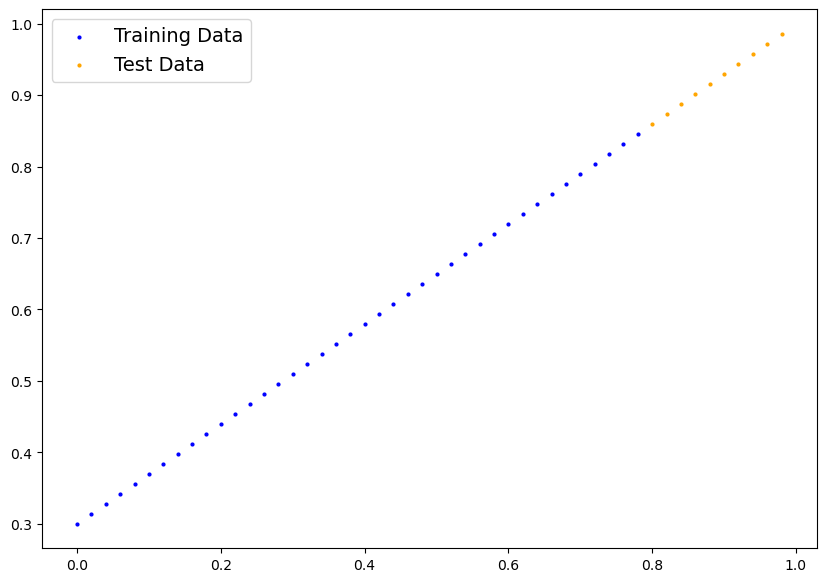

In [42]:
plot_predictions()

Now let's build a model that is able to predict the function based on the training set for the test set.

In [43]:
# Creating a linear regression model class

class LinearRegressionModel(nn.Module): # Almost everything in PyTorch inherits nn.Module
  def __init__(self):
    super().__init__() # We initialize the parent class by referring to it as super
    self.weight = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))
    self.bias = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))

  # Defining a forward function to represent the computation in model
  def forward(self, x: torch.Tensor) -> torch.Tensor:
     # We did a little bit of type hinting here, we'll dive into it better below. However, x is the input data here
    return self.weight * x + self.bias # We returned the value of the function as per the current model's state (weight, bias)
  

A couple of things to bring to light from the above code block:

* the `super` method calls the parent class and here we are initializing the parent nn.Module superclass
* the `requires_grad` argument asks PyTorch to keep track of gradients of the parameters as we will employ `gradient descent` and `back propagation` to update our parameters
* while defining the forward method we employed 'type hinting' which causes the method to expect a tensor as input and the `->` indicated that the method will return a tensor as well
* any subclass of nn.Module must override the forward method ( overridig is done by defining the method in the subclass again )

> What does the model do?

It:
* starts with random values for the parameters
* looks at the training data and adjust the random values to better suit or represent the ideal values

> How does it do so?

Through:
* Gradient Descent
* Back Propagation


## PyTorch Model Building Essentials

* torch.nn - contains all of the building blocks for computational graphs ( a neural network can be considered a computational graph)
* torch.nn.Parameters - what parameters should our model try to learn, often a PyTorch layer from torch.nn will set these for us
* torch.nn.Module - the base class for all neural network modules, don't forget to overwrite the forward method. The forward method defines wha happens in forward computation
* torch.optim - this is where all of the optimizers of PyTorch live, they determine the best values for our parameters via gradient descent


Let's see what's inside our model. The model parameters can be fetched with .parameters() method.

In [44]:
# Creating a random seed
torch.manual_seed(42)

# Creating an instance of the model
model_0 = LinearRegressionModel()
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

A better way to list out our parameters is through the .state_dict() method. As the name suggests, the method returns a dictionary containing current state information of the model as in the parameter values and so on.

In [45]:
model_0.state_dict()

OrderedDict([('weight', tensor([0.3367])), ('bias', tensor([0.1288]))])

## Making predictions with `torch.inference_mode()`

When we pass our data through a model, it is going to run it through the forward model. How well the model is able to guess the value of "Y_test" as per the provided "X_test" determines the predictive power / accuracy of our model.

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

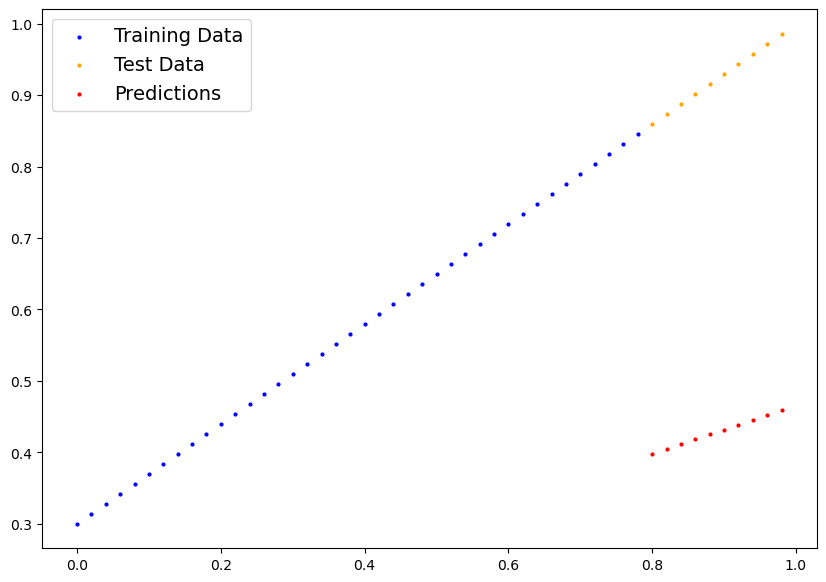

In [46]:
# We seen an application of context managers in python below. Context managers are used for resource management where resources no longer in use are automatically released by the program to accomodate for further resources.
with torch.inference_mode():
  y_preds_rand = model_0(X_test)

# We can have achieve similar results with the torch.no_grad() in the context manager however torch.inference_mode() has several benefits over no_grad() being a newer feature of PyTorch
# with torch.no_grad():
#   ypreds = model_0(X_test)

y_preds_rand
plot_predictions(predictions=y_preds_rand)

## Training our Model

The entire process of training revolves around starting with some arbitrary parameters (maybe random, maybe taken from some other models `transfer learning`), looking at the data we have, trying to figure out the underlying trend, rule, pattern etc. and changing our parameters to better represent the data we have. The model progressively gets better at predicting the output for an input as per the data's trend.

Quantifying the performance of our model allows for us to fine-tune it to be more accurate. One of the ways of doing so is through a `loss function`. Loss functions differ from cost functions in the way that cost functions find out how bad the model is, on average, at predicting the data for several sample inputs while a loss function evaluates how far a model's prediction is from the actual data (ideal prediction) for a single sample input.

Things we will need fot training our model:

  * **Loss Function** - Described above
  * **Optimizer** - Takes into account the loss of the prediction and adjusts the parameters such that the loss is minimized

And specifically for PyTorch we will need:
  * A training loop
  * A testing loop

In [47]:
# Setting up a loss function
loss_fn = nn.L1Loss() # Initializes the MAE (Mean Average Error) loss function

# Setting up a optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.01)  # Initializes  the SGD (Stochastic Gradient Descent) optimizer


While setting up our loss function, there are a few things to keep in mind
* **params** : the parameters that are to be optimized through training
* **lr** : the learning rate, one of the most important hyperparameters. Hyperparameters are set by engineers to allow for faster convergence (completion of learning or achievement of local minimum in cost-parameters hyperspace). Smaller lr can cause overfitting of data. Larger parameters can cause overshooting minimum due to large steps.

> Overfitting of data is a condition where the model learns the noise and idiosyncrasies of the training data  as if they were genuinely contributing to the underlying pattern, like a student that meticulously memorizes the concepts and notes without gaining the underlying understanding required to solve problems not previously discussed. The model will perform surprisingly well with samples from training data but are severely compromised when faced with new datasets.

In [48]:
loss_fn
optimizer 

L1Loss()

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.01
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)

### Building a training loop and testing loop

Thing we will need:
0. Loop through the data
1. Forward pass (passing the data through forward method of our model) to make predictions- aka Forward Propagation
2. Calculate Loss for the prediction (compare prediction with ground-truth labels)
3. Optimizer zero grad
4. Loss Backwards - to calculate the gradient of each parameters of the model with respect to loss (**backpropagation**)
5. Optimizer step - adjust our model parameters to improve our loss (**gradient dscent**)


In [49]:
epochs = 1 # An epoch is a loop through data
# 0. Loop through the data

for i in range(epochs):
  # Set the model in training mode
  model_0.train() # Sets all parameters in the model that require gradients to require gradients

  # 1. Forward pass
  Y_preds = model_0(X_train)

  # 2. Calculate the loss
  loss = loss_fn(Y_preds, Y_train)
  
  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Perform backpropagation on the loss with respect to the parameters of the model
  loss.backward()

  # 5. Step the optimizer (perform gradient descent)
  optimizer.step() # The optimizer steps will accumulate as we go through the loop. We can get similar idea from the fact that in back propagation the nudge to the parameters be it weight or bias depends not only on the sample training data evaluated but for all data in the set (true backprop). So in order to zero thee optimizer step we pass the statement in 3

  model_0.eval() # Turns off gradient tracking

LinearRegressionModel()

LinearRegressionModel()

In [50]:
# Refactoring the above cell into a function (recommended)
def model_train(model, labels, features, epochs, loss_function, optimizer):
  for i in range(epochs):
    model.train()
    predictions = model(features)
    loss = loss_function(predictions,labels)
    optimizer.zerograd()
    loss_function.backward()
    optimizer.step()
    model.eval()